In [3]:
from NFA import *
from RegexCompiler import *
from IPython.display import display

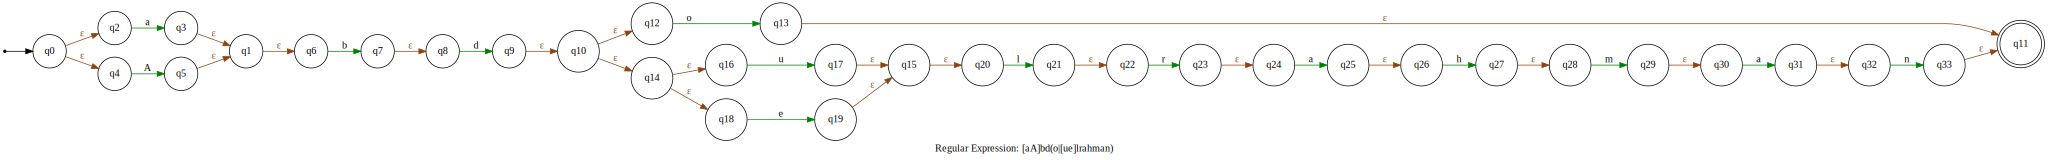

Match string:  Abdo
Match Result:  True


In [4]:
expr = "[aA]bd(o|[ue]lrahman)"
text = "Abdo"
nfa = regex_to_nfa(expr)
dot = nfa.to_dot(expr)
display(dot)
print("Match string: ", text)
print("Match Result: ", nfa.match(text))